In [8]:
import sqlite3
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pydicom
from PIL import Image


DB_PATH = r"D:\Digital_Pathology_Edge\data\raw\train\MITOS_WSI_CCMCT_ODAEL_train_dcm.sqlite"
WSI_DIR = r"D:\Digital_Pathology_Edge\data\raw\train"

conn = sqlite3.connect(DB_PATH)

tables = ["Slides", "Classes", "Persons", "Annotations", 
          "Annotations_coordinates", "Annotations_label", "Log"]

dfs = {}
for t in tables:
    dfs[t] = pd.read_sql_query(f"SELECT * FROM {t};", conn)
    print(f"Loaded {t}: {len(dfs[t])} rows")

slides_df = dfs["Slides"]
annotations_df = dfs["Annotations"]
coords_df = dfs["Annotations_coordinates"]
labels_df = dfs["Annotations_label"]



Loaded Slides: 21 rows
Loaded Classes: 7 rows
Loaded Persons: 5 rows
Loaded Annotations: 158912 rows
Loaded Annotations_coordinates: 158929 rows
Loaded Annotations_label: 358255 rows
Loaded Log: 0 rows


In [9]:
slide_row = slides_df.iloc[0]
slide_filename = slide_row['filename']

print("Selected slide:", slide_filename)
print(slide_row)



Selected slide: c3eb4b8382b470dd63a9.dcm
uid                                                          4
filename                              c3eb4b8382b470dd63a9.dcm
width                                                    82799
height                                                   54996
directory                                                 None
uuid         1.2.276.0.7230010.3.1.3.8323329.7874.157959484...
Name: 0, dtype: object


In [26]:
import openslide
import os

dcm_path = os.path.join(WSI_DIR, slide_filename)

slide = openslide.OpenSlide(dcm_path)
print(slide.level_dimensions)
print(slide.level_count)



((82799, 54996),)
1


In [19]:
import numpy as np
import pydicom
from pydicom.encaps import decode_data_sequence
from PIL import Image
import io
import matplotlib.pyplot as plt


class TileWSI:
    def __init__(self, path):
        ds = pydicom.dcmread(path)
        self.ds = ds

        # Tile size (rows, columns)
        self.tile_h = ds.Rows
        self.tile_w = ds.Columns

        # Full-resolution size (width, height)
        self.full_w = ds[0x0048,0x0006].value   # TotalPixelMatrixColumns
        self.full_h = ds[0x0048,0x0007].value   # TotalPixelMatrixRows

        # Number of tiles in grid
        self.tiles_x = int(np.ceil(self.full_w / self.tile_w))
        self.tiles_y = int(np.ceil(self.full_h / self.tile_h))

        # Decode JPEG tiles
        self.tiles = decode_data_sequence(ds.PixelData)

    def tile_index(self, tx, ty):
        return ty * self.tiles_x + tx

    def get_tile(self, tx, ty):
        idx = self.tile_index(tx, ty)
        if idx >= len(self.tiles):
            return None
        tile_bytes = self.tiles[idx]
        return np.array(Image.open(io.BytesIO(tile_bytes)))

    def read_region(self, location, size):
        x, y = location
        w, h = size

        # tile grid regions
        tile_x_start = x // self.tile_w
        tile_y_start = y // self.tile_h
        tile_x_end   = (x + w) // self.tile_w
        tile_y_end   = (y + h) // self.tile_h

        # create large buffer
        region = np.zeros(( (tile_y_end-tile_y_start+1)*self.tile_h,
                            (tile_x_end-tile_x_start+1)*self.tile_w, 
                            3), dtype=np.uint8)

        # fill it with tiles
        for ty in range(tile_y_start, tile_y_end+1):
            for tx in range(tile_x_start, tile_x_end+1):
                tile = self.get_tile(tx, ty)
                if tile is None:
                    continue
                yy = (ty - tile_y_start) * self.tile_h
                xx = (tx - tile_x_start) * self.tile_w
                region[yy:yy+self.tile_h, xx:xx+self.tile_w] = tile

        # crop to requested size
        off_x = x - tile_x_start * self.tile_w
        off_y = y - tile_y_start * self.tile_h
        return region[off_y:off_y+h, off_x:off_x+w]


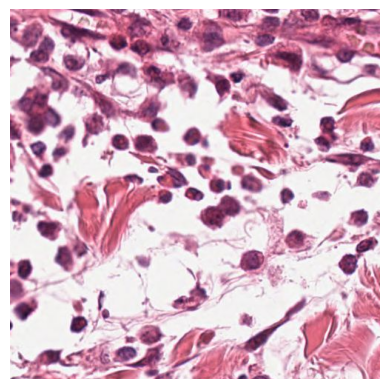

In [35]:
slide = TileWSI(r"D:\Digital_Pathology_Edge\data\raw\train\fff27b79894fe0157b08.dcm")
half = 500 // 2
cx = max(0, 21763 - half)
cy = max(0, 77042 - half)
patch = slide.read_region((cx, cy), (500, 500))

plt.imshow(patch)
plt.axis("off")
plt.show()



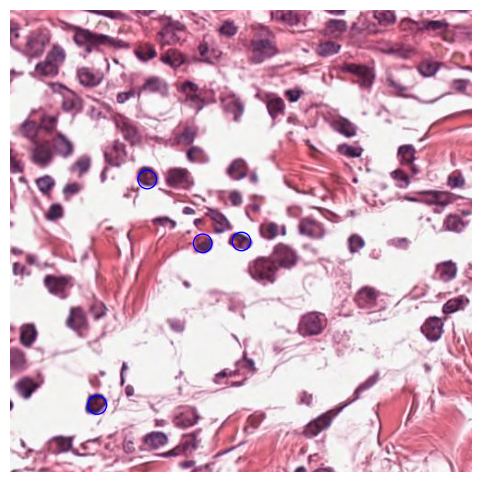

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

db_path = r"D:\Digital_Pathology_Edge\data\raw\train\MITOS_WSI_CCMCT_ODAEL_train_dcm.sqlite"
slide_filename = "fff27b79894fe0157b08.dcm"
anno_id = 41808   #annoID --> each has diff x and y coords
PATCH_SIZE = 500


conn = sqlite3.connect(db_path)
slides = pd.read_sql_query("SELECT * FROM Slides", conn)
coords = pd.read_sql_query("SELECT * FROM Annotations_coordinates", conn)
conn.close()

# map filename to slide UID
slide_row = slides[slides['filename'] == slide_filename]
if slide_row.empty:
    raise ValueError("Slide not found")
slide_uid = slide_row['uid'].iloc[0]

# filter annotation coordinates
anno_points = coords[(coords['annoId']==anno_id) & (coords['slide']==slide_uid)]
if anno_points.empty:
    raise ValueError("No coordinates found for this annotation")

# keep the point at the center
ax = int(anno_points['coordinateX'].iloc[0])
ay = int(anno_points['coordinateY'].iloc[0])
half = PATCH_SIZE // 2
cx = max(0, ax - half)
cy = max(0, ay - half)

slide_path = rf"D:\Digital_Pathology_Edge\data\raw\train\{slide_filename}"
slide = TileWSI(slide_path)
patch = slide.read_region((cx, cy), (PATCH_SIZE, PATCH_SIZE))

anno_points = coords[
    (coords['slide'] == slide_uid) &
    (coords['coordinateX'] >= cx) &
    (coords['coordinateX'] < cx + PATCH_SIZE) &
    (coords['coordinateY'] >= cy) &
    (coords['coordinateY'] < cy + PATCH_SIZE)
]

plt.figure(figsize=(6,6))
plt.imshow(patch)
plt.axis('off')

for _, row in anno_points.iterrows():
    px = row['coordinateX'] - cx  
    py = row['coordinateY'] - cy
    plt.gca().add_patch(Circle((px, py), radius=10, edgecolor='blue', facecolor='none', linewidth=1))

plt.show()